In [213]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
import os
import subprocess
import json
import sys


In [135]:
#file names, should try to automate more
VCF_FILE_NAME = 'ERR6634978_q20.recode.vcf.gz'
VCF_PATH = '../../../data/processed/freebayesVCF'
VCF_FILE_PATH = os.path.join(VCF_PATH, VCF_FILE_NAME)
JSON_FILE_PATH = os.path.join(VCF_PATH, 'results/ERR6634978.results.json')

In [136]:
#tried to recognise whether if the vcf file is in gz format, if not, compress it
# import re

# if re.match('*vcf$',VCF_FILE_NAME):
#     print('Please input .vcf.gz format file compresed using bgzip')


In [ ]:
#running tb-profiler to identify drug resistance for the sample
#need to be run in tb-profiler environment, somehow failed to download tb-profiler in ml-s7, so far this part is run out side python in bash
subprocess.call(['tb-profiler', 'vcf_profile', VCF_FILE_PATH])


In [ ]:
#read in the drug resistance labeled file generated from tb-profiler
with open(JSON_FILE_PATH, 'r') as f:
    json_labelling = json.load(f)

In [ ]:
#get the reference read and alternative read count, changing environment is somehow not working in python
env_command = 'eval "$(conda shell.bash hook)"; conda activate tb-profiler'
subprocess.run(env_command, shell=True)

with open('ROAO_proportion.csv', 'w') as f:
    subprocess.run(['bcftools', 'query', '-f', '[%POS,%RO,%AO\n]', VCF_FILE_PATH], shell=False, stdout=f, text=True)


Could not find conda environment: tb-profiler
You can list all discoverable environments with `conda info --envs`.



In [139]:
#count how many column there is in the ROAO_proportion.csv file this is needed in order to read the csv in a a panda dataframe
import csv

f = open('ROAO_proportion.csv')

data = []
num_col=0
for line in f:
    data_line = line.rstrip().split('\n')
    data_line = data_line[0].split(',')
    data_line = [int(i) for i in data_line]
    if len(data_line) > num_col:
        num_col = len(data_line)
    data.append(data_line)

print(num_col)
num_RO = num_col - 1
print(num_RO)


4
3


In [ ]:
for reads in json_labelling['dr_variants']:
    print(reads['genome_pos'])
    for i in reads['drugs']:
        print(i['drug'])

for reads in json_labelling['other_variants']:
    print(reads['genome_pos'])
    print(reads['gene_associated_drugs'])

In [150]:
#reading csv as pandas dataframe and create a numpy array version of it
df = pd.read_csv('ROAO_proportion.csv', names=range(num_col)) #doesn't include the 4th colum
df.fillna(value=0, inplace=True)
df[num_col] = None #create 4th column here as a empty column of zero, this column is for the drug resistance info
df_np = df.to_numpy()



In [244]:

#numpy array and json file compared against each other in terms of genome position and 
#the drug resistance info is added on to the 4th column of the numpy array if there is a match in genome position
for ind, pos in enumerate(df_np[:,0]): 
    for reads in json_labelling['dr_variants']:
        if pos == reads['genome_pos']:
            # print('hit: ', pos)
            for i in reads['drugs']:
                df_np[ind, 4] = [i['drug']]

for ind, pos in enumerate(df_np[:,0]):
    for reads in json_labelling['other_variants']:
        if pos == reads['genome_pos']:
            # print('hit: ', pos)
            df_np[ind, 4] = reads['gene_associated_drugs']


hit:  761155
hit:  2155168
hit:  4247429
hit:  7362
hit:  7585
hit:  9304
hit:  764817
hit:  764995
hit:  781395
hit:  1416222
hit:  1471659
hit:  1917972
hit:  3073868
hit:  3086788
hit:  4239763
hit:  4242643
hit:  4408156


In [158]:
#training gaussianMixture Model

from sklearn.mixture import GaussianMixture

model_input = df_np[:,1:num_col]
gm = GaussianMixture(n_components=num_RO, random_state=0).fit(model_input)

In [245]:
#create number of strain number of object in a dictionary
resistance_dict = {}

for x in range(1,num_RO+1):
    resistance_dict['strain'+ str(x)] = []

resistance_dict

{'strain1': [], 'strain2': [], 'strain3': []}

In [246]:
#reads are assigned to different strains according to their ROAO by the gaussianMixture model
#and added to the corresponding strain item in dictionary

for x in df_np:
    if x[num_col] != None:
        output = gm.predict([x[1:num_col]])
        # print(output)

        for i in range(1,num_RO+1):
            if output == [i-1]:
                # if x[num_col] in resistance_dict['strain'+ str(i)]:
                #     continue
                resistance_dict['strain'+ str(i)].extend(x[num_col])
                # print(x[num_col], 'added')


['fluoroquinolones', 'levofloxacin', 'moxifloxacin', 'ciprofloxacin', 'ofloxacin'] added
['fluoroquinolones', 'levofloxacin', 'moxifloxacin', 'ciprofloxacin', 'ofloxacin'] added
['fluoroquinolones', 'levofloxacin', 'moxifloxacin', 'ciprofloxacin', 'ofloxacin'] added
['rifampicin'] added
['rifampicin'] added
['rifampicin'] added
['streptomycin'] added
['ethambutol'] added
['amikacin', 'aminoglycosides', 'kanamycin', 'streptomycin', 'capreomycin'] added
['capreomycin'] added
['isoniazid'] added
['para-aminosalicylic_acid'] added
['cycloserine'] added
['ethambutol'] added
['ethambutol'] added
['ethambutol'] added
['streptomycin'] added


/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/mnt/storage7/lwang/miniconda3/envs/ml-s7/lib/python3.10/site-packages/sklearn/base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (ren

In [249]:
#remove ducplicate items and show the dictionary as a df
for x in range(1,num_RO+1):
    resistance_dict['strain'+ str(x)] = np.unique(resistance_dict['strain'+ str(x)])

pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in resistance_dict.items() ]))

,strain1,strain2,strain3
0,ethambutol,amikacin,NaN
1,NaN,aminoglycosides,NaN
2,NaN,capreomycin,NaN
3,NaN,ciprofloxacin,NaN
4,NaN,cycloserine,NaN
5,NaN,ethambutol,NaN
6,NaN,fluoroquinolones,NaN
7,NaN,isoniazid,NaN
8,NaN,kanamycin,NaN
9,NaN,levofloxacin,NaN


<BarContainer object of 1171 artists>

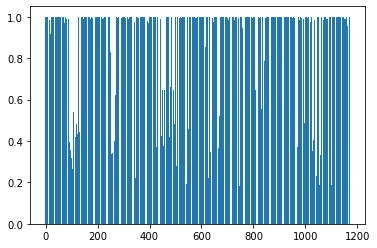

In [262]:
#frequency graph assuming that there is only two strains
df_2component = pd.read_csv('ROAO_proportion.csv', names=range(3))
df_2component['proportion'] = df_2component[2]/(df_2component[1]+df_2component[2]) # alt/(ref+alt)

fig, ax= plt.subplots()
ax.bar(np.arange(len(df_2component[2])),df_2component['proportion'])
